# Field Parameter Estimation 2 

`9-13-22`

- Testing field parameters calculation after field isolation 

In [1]:
import torch
import numpy as np
import PIL
from tqdm import tqdm
from PIL import Image
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from matplotlib import pyplot as plt
import sys  
import os
from pathlib import Path
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
import numpy as np

# Set Root Directory
root = Path('/mnt/c/Users/Samarth Negi/Desktop/soccerEye')
sys.path.insert(0, str(root))


from IPython.display import Video
import cv2
import methods 
import utils


In [2]:
# Set Dataset Path
dataset = Path('../dataset/df-bl/')
dataset = dataset.resolve()
print(f'Dataset Location : {dataset}')
dataset_files = utils.util_searching_all_files(dataset)
print(f'Number of files in dataset : {len(dataset_files)}')

Dataset Location : /mnt/c/Users/Samarth Negi/Desktop/soccerEye/dataset/df-bl
Number of files in dataset : 12


In [3]:
CHECKPOINT_LOCATION = '../weights/FPN_FieldMask_1/checkpoints/epoch=49-step=600.ckpt'

In [8]:
videoPick = np.random.randint(len(dataset_files))
print(f'Video Picked (index) : {videoPick}')
cap = cv2.VideoCapture(str(dataset_files[videoPick]))
videoPick = 11

Video Picked (index) : 0


## Working Area : One Frame

In [28]:
total_frames = cap.get(7)
print(total_frames)
cap.set(1, np.random.randint(total_frames))
ret, frame = cap.read()

85915.0


In [29]:
frame_w = frame.shape[1]
frame_h = frame.shape[0]

In [30]:
# Getting Field Isolate 
# Getting field mask 
frame_fm = methods.P_IF_4_FPN_CV2(frame,CHECKPOINT_LOCATION,inputType = 'single',device='cpu')

# Resize
frame_fm_sized = cv2.resize(frame_fm, (frame_w,frame_h), interpolation = cv2.INTER_LINEAR )
frame_fm_sized_binary = cv2.normalize(frame_fm_sized, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_8U)

# Create Field Isolate
field_isolate = cv2.bitwise_and(frame,frame,mask = frame_fm_sized_binary)


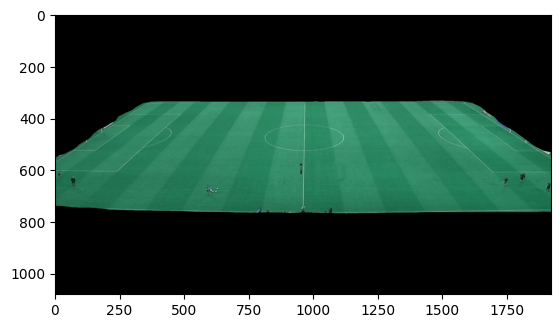

In [31]:
imshow(field_isolate)

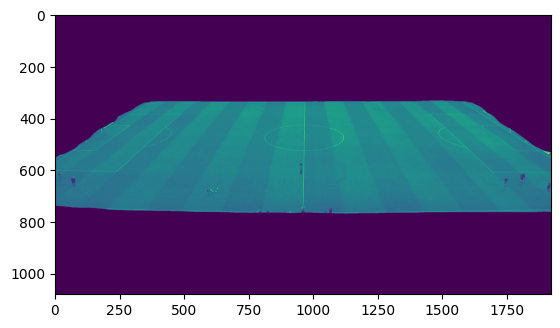

In [32]:
f_i_gray = cv2.cvtColor(field_isolate, cv2.COLOR_BGR2GRAY)
imshow(f_i_gray)

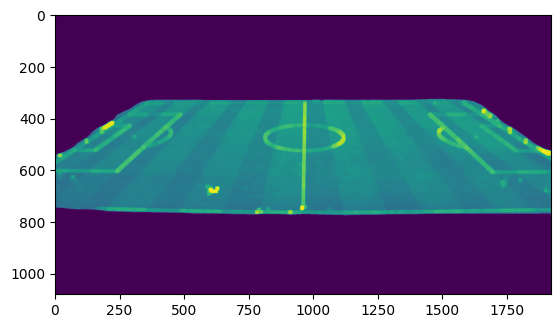

In [33]:
# Edges Dialater
thr1=50
thr2=200
kernel = np.ones((5,5 ),np.float32)/49
f_i_gray_dialate = cv2.dilate(f_i_gray, kernel, iterations=3)
imshow(f_i_gray_dialate)

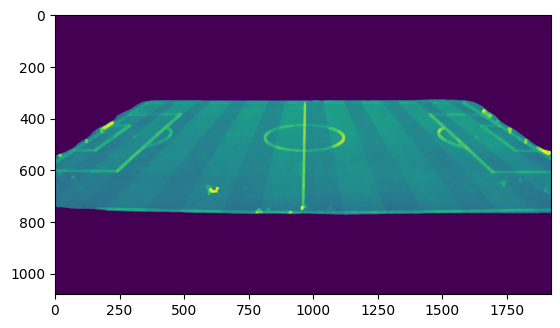

In [34]:
# Eroded Edges
f_i_gray_dialate_erode = cv2.erode(f_i_gray_dialate, kernel, iterations=1)
imshow(f_i_gray_dialate_erode)

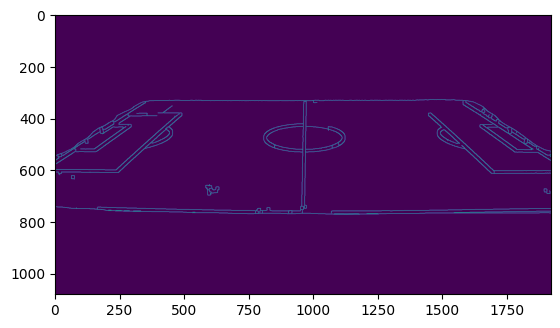

In [35]:
# Thresholded Canny 
f_i_gray_dialate_erode_canny = cv2.Canny(f_i_gray_dialate_erode, thr1, thr2)
imshow(f_i_gray_dialate_erode_canny)

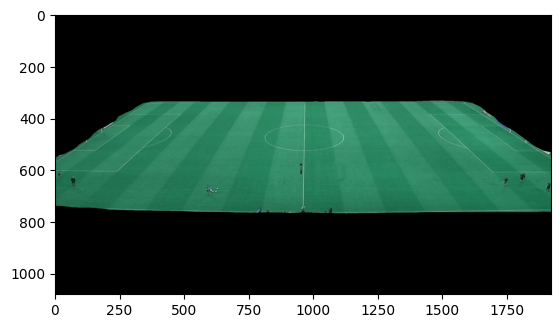

In [38]:
imshow(field_isolate)

In [39]:
rho = 1  # distance resolution in pixels of the Hough grid
theta = np.pi / 180  # angular resolution in radians of the Hough grid
threshold = 15  # minimum number of votes (intersections in Hough grid cell)
min_line_length = 100  # minimum number of pixels making up a line
max_line_gap = 20  # maximum gap in pixels between connectable line segments
line_image = np.copy(field_isolate) * 0  # creating a blank to draw lines on
overlap_image = np.copy(field_isolate)

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
lines = cv2.HoughLinesP(f_i_gray_dialate_erode_canny, rho, theta, threshold, np.array([]),
                    min_line_length, max_line_gap)

for line in lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
        cv2.line(overlap_image,(x1,y1),(x2,y2),(255,0,0),5)        

## Working Area : Full Video

In [41]:
total_frames = cap.get(7)
print(total_frames)
cap.set(1, np.random.randint(total_frames))
ret, frame = cap.read()

85915.0


In [47]:
w = frame.shape[1]
h = frame.shape[0]

print(f'Image w : {w}, h : {h}')

Image w : 1920, h : 1080


In [68]:




out = cv2.VideoWriter('../outputs/field_parameter_test.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 10, (w*2,h))
out2 = cv2.VideoWriter('../outputs/field_parameter_test_2.mp4', cv2.VideoWriter_fourcc(*'MP4V'), 10, (w,h))




for frameNo in tqdm(range(10000,10500)):
    cap.set(1, frameNo)
    ret, frame = cap.read()
    # Getting Field Isolate -------------------------------------------------------------------------------------------------
    # Getting field mask 
    frame_fm = methods.P_IF_4_FPN_CV2(frame,CHECKPOINT_LOCATION,inputType = 'single',device='cpu')

    # Resize
    frame_fm_sized = cv2.resize(frame_fm, (w,h), interpolation = cv2.INTER_LINEAR )
    frame_fm_sized_binary = cv2.normalize(frame_fm_sized, None, 0, 1, cv2.NORM_MINMAX, cv2.CV_8U)

    # Create Field Isolate
    field_isolate = cv2.bitwise_and(frame,frame,mask = frame_fm_sized_binary)
    
    # Preprocessing for line finding -------------------------------------------------------------------------------------------------
    f_i_gray = cv2.cvtColor(field_isolate, cv2.COLOR_BGR2GRAY)
    
    thr1=50
    thr2=200
    kernel = np.ones((5,5 ),np.float32)/49
    f_i_gray_dialate = cv2.dilate(f_i_gray, kernel, iterations=3)

    f_i_gray_dialate_erode = cv2.erode(f_i_gray_dialate, kernel, iterations=1)

    f_i_gray_dialate_erode_canny = cv2.Canny(f_i_gray_dialate_erode, thr1, thr2)
    rho = 1  # distance resolution in pixels of the Hough grid
    theta = np.pi / 180  # angular resolution in radians of the Hough grid
    threshold = 15  # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 100  # minimum number of pixels making up a line
    max_line_gap = 20  # maximum gap in pixels between connectable line segments
    line_image = np.copy(field_isolate) * 0  # creating a blank to draw lines on
    overlap_image = np.copy(field_isolate)
    
    # Plotting Lines -------------------------------------------------------------------------------------------------
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(f_i_gray_dialate_erode_canny, rho, theta, threshold, np.array([]),
                        min_line_length, max_line_gap)

    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),5)
            cv2.line(overlap_image,(x1,y1),(x2,y2),(255,0,0),5)       
           
    # Generating Output -------------------------------------------------------------------------------------------------
    top = np.concatenate((frame,field_isolate),axis = 1)
    bottom = np.concatenate((line_image,overlap_image),axis = 1)
    full = np.concatenate((top,bottom),axis = 0)
    
    full_resized_h = int(full.shape[0]/2)
    full_resized_w = int(full.shape[1]/2)
    
    full_resized = cv2.resize(full, (full_resized_w,full_resized_h), interpolation = cv2.INTER_LINEAR )
    
    out.write(bottom)
    out2.write(full_resized)
    
    
    
out.release()
out2.release()
    
    

OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
OpenCV: FFMPEG: tag 0x5634504d/'MP4V' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'
100%|██████████████████████████████████████████████████████████████████████████████| 500/500 [14:09<00:00,  1.70s/it]


In [64]:
full.shape[0]/2

1080.0